In [2]:
# Necessary imports and plot setup
import pandas as pd
import numpy as np
from get_sentiment import *
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
plt.rc('font', weight='bold', size=15)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dizquierdo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# DataFrame Setup

In [ ]:
# Set up sentiment analysis
sentiment_analyzer = SentimentIntensityAnalyzer()
def sentiment(doc):
    """Returns polarity score set earlier to Vader's analyzer"""
    return sentiment_analyzer.polarity_scores(doc)['compound']

### Candidates

In [158]:
# Read in Candidate tweets
results = primary_species(['Candidate', 'Tweet'], 'text', 'timestamp')
cand_data = read_cypher(results, index_col='timestamp')

In [159]:
# Check number of tweets by candidate
cand_data.name.value_counts()

BernieSanders    168
ewarren          145
PeteButtigieg    113
MikeBloomberg     99
amyklobuchar      91
JoeBiden          80
AndrewYang        36
TulsiGabbard      21
Name: name, dtype: int64

In [160]:
# Total tweets in this set
len(cand_data)

753

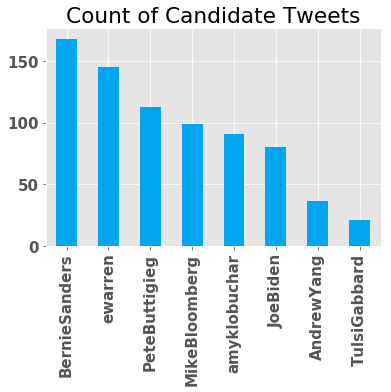

In [275]:
# Quick visualization of above
plt.title('Count of Candidate Tweets')
cand_data.name.value_counts().plot(kind='bar', color='#00A6EF');

In [ ]:
# Handle preprocessing and cleaning of data
cand_data['clean_text'], cand_data['hashtag'] = zip(*cand_data.text.map(strip_tweets))
cand_data = pd.merge(cand_data, pd.get_dummies(cand_data.hashtag.apply(pd.Series).stack()).sum(level=0), how='left', left_index=True, right_index=True).drop(['hashtag','followers'], axis=1).fillna(0)
cand_data['sentiment'] = cand_data.text.apply(sentiment)
cand_data.set_index(pd.to_datetime(cand_data.timestamp,unit='s'), inplace=True)
cand_data['day'] = cand_data.index.day
cand_data.drop(['timestamp'], axis=1, inplace=True)

### General population

In [97]:
# Read in general tweets
com_results = f"""
MATCH (u:User)-[ts:TWEETS]-(t:Tweet)-[:CONTAINS]-(c:Candidate)
WHERE EXISTS (ts.timestamp)
RETURN c.screen_name as name, c.followers as followers, t.text as text, ts.timestamp as timestamp
"""
raw_data = read_cypher(com_results, index_col='timestamp')

In [128]:
# Check counts
raw_data.name.value_counts()

BernieSanders    38957
ewarren          16835
JoeBiden         13318
MikeBloomberg     9715
PeteButtigieg     9140
AndrewYang        2940
amyklobuchar      2555
TulsiGabbard      1194
Name: name, dtype: int64

In [129]:
len(raw_data)

94654

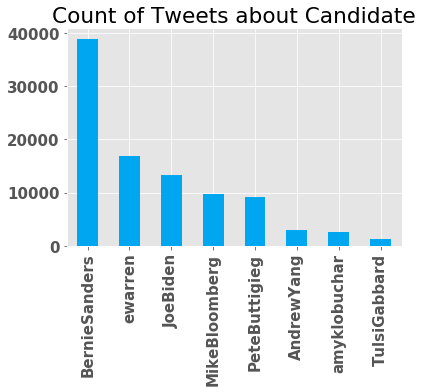

In [276]:
# Quick visualization of above
plt.title('Count of Tweets about Candidate')
raw_data.name.value_counts().plot(kind='bar', color='#00A6EF');

In [131]:
# Sample above data for ease of processing
data = raw_data.sample(frac=.1)
data['clean_text'], data['hashtag'] = zip(*data.text.map(strip_tweets))
data = pd.merge(data, pd.get_dummies(data.hashtag.apply(pd.Series).stack()).sum(level=0), how='left', left_index=True, right_index=True).drop(['hashtag','followers'], axis=1).fillna(0)
data['sentiment'] = data.text.apply(sentiment)
data.set_index(pd.to_datetime(data.timestamp,unit='s'), inplace=True)
data['day'] = data.index.day
data.drop(['timestamp'], axis=1, inplace=True)

### Check processed DataFrames

In [334]:
cand_data.head()

,name,text,clean_text,#1,#BloombergGBF,#CNNTownHall,#CNNTownhall,#CoronavirusUSA,#DemDebate,#FocusonTheIssues,...,#WeNeedToKnow,#WealthTax,#danggang,#masendebate,#sb150,#southbend,#stuffmayorsdo,#yanggang,sentiment,day
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-02-27 21:57:55,BernieSanders,We're here in North Carolina to send a powerfu...,We're here in North Carolina to send a powerfu...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4215,27
2019-10-29 22:10:43,BernieSanders,The ideas I am talking to you about didn't com...,The ideas I am talking to you about didn't com...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.3182,29
2020-01-24 01:38:53,BernieSanders,“I think I'll probably vote for Bernie... He’s...,“I think I'll probably vote for Bernie... He’s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,24
2020-02-27 04:11:02,BernieSanders,"We're building a multiracial, multigenerationa...","We're building a multiracial, multigenerationa...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.4588,27
2020-02-14 03:47:08,BernieSanders,It has never made sense to me that a tiny grou...,It has never made sense to me that a tiny grou...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.4939,14


In [132]:
data.head()

,name,text,clean_text,#1,#2,#2020BlueTsunami,#2020Talks,#2PercentPete,#2ndAmendment,#44,...,#tytlive,#voteklobnomatterwob,#voting,#wallstreetpete,#wevapewevote,#woke,#worstimpotusever,#yangang,sentiment,day
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-02-26 20:09:04,ewarren,@JHarrisonCowan @hawaii50bruh @ewarren No doub...,No doubt.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.5719,26
2020-02-26 23:30:58,PeteButtigieg,@B00T_EDGE_EDGE @PeteButtigieg our movement is...,"our movement is multiracial, cross-generatio...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,26
2020-02-26 19:57:11,PeteButtigieg,@KennethNadel @HumanistReport @PeteButtigieg @...,The previous Democrat got ten points higher.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,26
2020-02-27 23:23:01,BernieSanders,@CANCEL_SAM @BernieSanders Lame ass ad,Lame ass ad,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.7430,27
2020-02-25 22:52:58,BernieSanders,@FrankRedfoot @_Brahbra @Antifada161 @OnlyReal...,That’s why it does…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,25


In [134]:
# Quick check of average candidate sentiments
data.groupby(by='name').sentiment.mean()

name
AndrewYang       0.121484
BernieSanders    0.022224
JoeBiden         0.033757
MikeBloomberg    0.040540
PeteButtigieg    0.050915
TulsiGabbard     0.037383
amyklobuchar     0.098503
ewarren          0.052181
Name: sentiment, dtype: float64

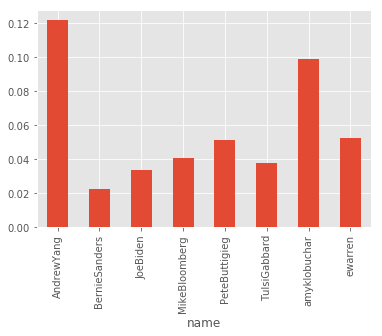

In [137]:
# Visualization of above
candidate_mean = data['2020-02-25':'2020-02-29'].groupby('name').sentiment.mean()
candidate_mean.plot(kind='bar');

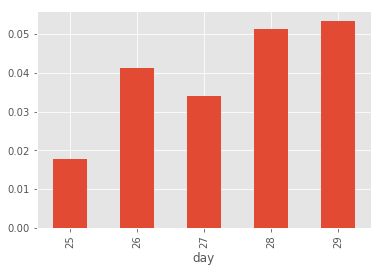

In [138]:
# Check average sentiment by day
day_mean = data['2020-02-25':'2020-02-29'].groupby('day').sentiment.mean()
day_mean.plot(kind='bar');

## Sentiment Visualizations

### Sentiment Distributions

#### Candidate

Let's take a look at the distribution of sentiments by candidates using a 5 number summary with boxplots and how they're spread across it using a swarmplot. Additionally call out the extreme values and grab their text (formatting here can use some iterating)

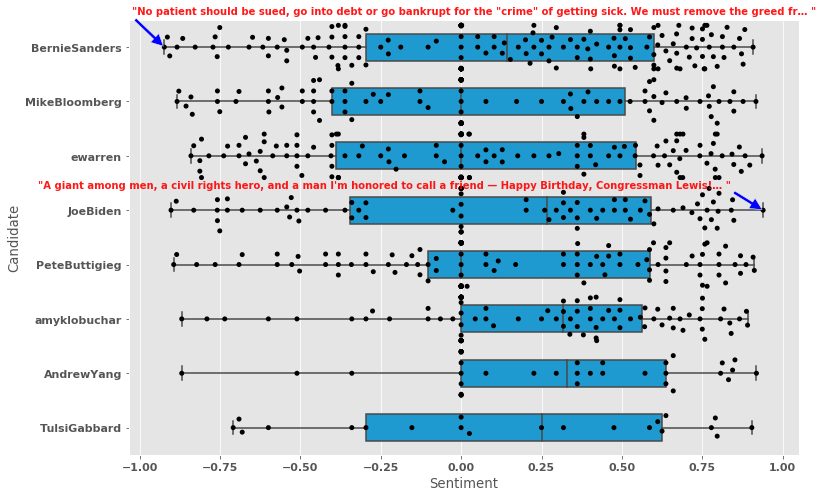

In [401]:
# Grab extreme values
max_sentiment = cand_data.sentiment.max()
min_sentiment = cand_data.sentiment.min()
max_sent_tweet = cand_data[(cand_data['sentiment'] == max_sentiment)]['clean_text'].values[0]
min_sent_tweet = cand_data[(cand_data['sentiment'] == min_sentiment)]['clean_text'].values[0]
max_sent_sender = cand_data[(cand_data['sentiment'] == max_sentiment)]['name'].values[0]
min_sent_sender = cand_data[(cand_data['sentiment'] == min_sentiment)]['name'].values[0]

# Set up combined plot
g = sns.boxplot(y = "name",
              x = 'sentiment', 
              data = cand_data, whis=np.inf, width=.5, color='#00A6EF')
g = sns.swarmplot(y = "name",
              x = 'sentiment', 
              data = cand_data,
              size = 5,color='black')
plt.ylabel('Candidate')
plt.xlabel('Sentiment')

# Figure out which candidate had the max values
for count, tick in enumerate(g.yaxis.get_major_ticks()):
    if max_sent_sender == tick.label.get_text():
        max_sent_y = count
    if min_sent_sender == tick.label.get_text():
        min_sent_y = count

# Annotate the extreme values
plt.annotate(s = '"'+max_sent_tweet+'"',
             xy = (max_sentiment,max_sent_y),
             xytext = (max_sentiment-.1,max_sent_y-.4), 
             # Shrink the arrow to avoid occlusion
             arrowprops = {'facecolor':'blue', 'width': 3, 'shrink': 0.03},
             ha='right',
             alpha=.9,
             color = 'red', size='10')
plt.annotate(s = '"'+min_sent_tweet+'"',
             xy = (min_sentiment,min_sent_y),
             xytext = (min_sentiment-.1,min_sent_y-.6), 
             # Shrink the arrow to avoid occlusion
             arrowprops = {'facecolor':'blue', 'width': 3, 'shrink': 0.03},
             horizontalalignment='left',
             alpha=.9,
             color = 'red', size='10')
g.figure.set_size_inches(12,8)
plt.show();

#### General Public

Repeat the above process for the tweets sent by the general population. Annotation was harder to fit here due to the increased number of points. Could not figure out how to set the order in time so ended up with a plot that was mostly accurate (sorry!). 

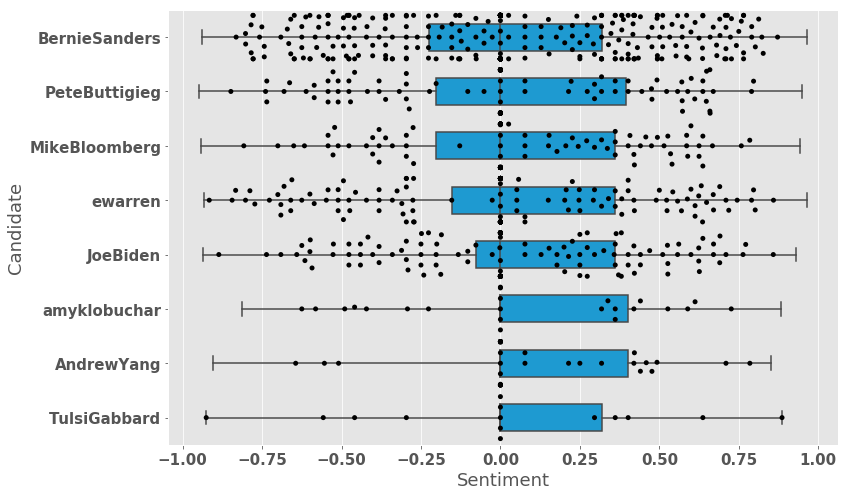

In [331]:

g = sns.boxplot(y = "name",
              x = 'sentiment', 
              data = data, whis=np.inf, width=.5, color='#00A6EF',
              order=['BernieSanders','ewarren','JoeBiden','MikeBloomberg','PeteButtigieg','AndrewYang',
                     'amyklobuchar','TulsiGabbard'])
g = sns.swarmplot(y = "name",
              x = 'sentiment', 
              data = data.sample(frac=.1),
              size = 5,color='black')
plt.ylabel('Candidate')
plt.xlabel('Sentiment')
g.figure.set_size_inches(12,8)
plt.show();

In [243]:
# Helper function to convert times to angles for polar coordinate chart
def winter_time(t_index):
    """Convert DateTime to equivalent polar coordinate 0=Midnight, Pi=Noon. Vectorize if possible."""
    since_midnight = t_index.hour * 3600 + t_index.minute * 60 + t_index.second
    polar_time = np.pi*2*since_midnight /60/60/24
    return polar_time.values

### Sentiment By Time of Day

#### Candidate

In [143]:
# Sorry everyone else
real_candidates = ['MikeBloomberg','BernieSanders','JoeBiden', 'ewarren']

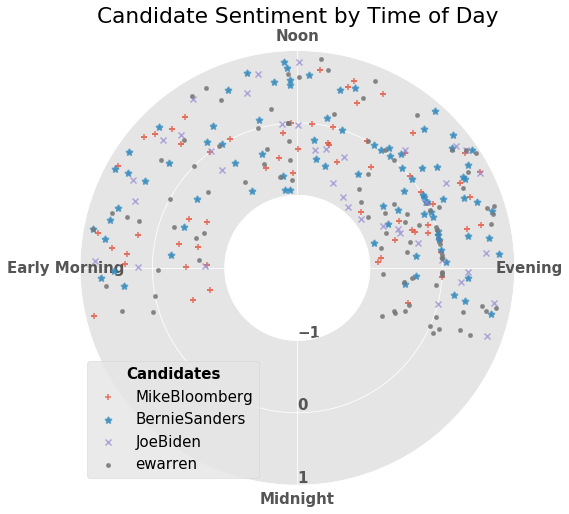

In [345]:
# Set up subplots and legend
fig, axes = plt.subplots(1,len(real_candidates), figsize=(12,8))
legends = {'ewarren': '.', 'BernieSanders':'*', 'MikeBloomberg':'+', 'JoeBiden':'x'}
for count, candidate in enumerate(real_candidates):
    # Find just the tweets from the relevant days (some retweets were of very old tweets)
    subset = cand_data['2020-02-25':'2020-03-03'].query(f'name=="{candidate}"')
    
    # Convert time of day to an angle
    subset['theta'] = winter_time(subset.index)
    fig = plt.subplot(polar=True)
    ax = plt.gca()
    ax.set_rorigin(-2)
    ax.set_rlim(-1,1)
    # Set it up so that midnight is South for improved legibility
    ax.set_theta_zero_location('S', 210)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(210)
    offset = [210,300,30,120]
    ax.set_rticks([-1,0,1])
    ax.set_thetagrids(angles = offset,
                      labels = ('Midnight', 'Early Morning', 'Noon', 'Evening'))
    c = ax.scatter(subset['theta'], subset['sentiment'], alpha=0.75, marker=legends[candidate], linewidths=2)
    plt.legend(real_candidates, title='Candidates', prop={'weight':'normal'})
    plt.title('Candidate Sentiment by Time of Day')

#### General Public

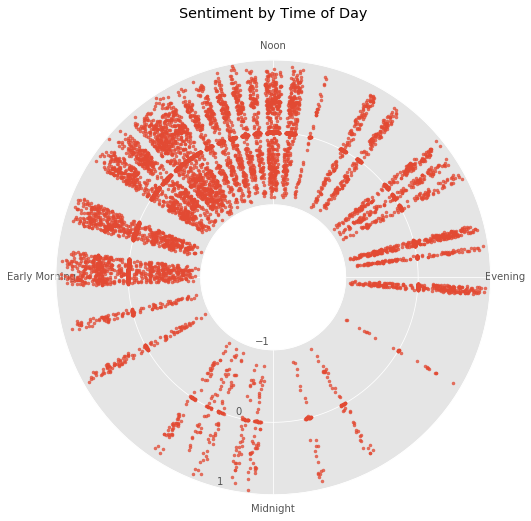

In [142]:
## This visualization suggests a systemic problem with how i've sampled or processed data into my database. Further investigation needed

# Find just the tweets from the relevant days (some retweets were of very old tweets)
subset = data['2020-02-25':'2020-03-03']
fig = plt.figure(figsize=(12,8))
r = subset.sentiment
# Convert time of day to an angle
subset['theta'] = winter_time(subset.index)
ax = fig.add_subplot(111, polar=True)
ax.set_rorigin(-2)
ax.set_rlim(-1,1)
ax.set_rgrids([-1,0,1])
# Set it up so that midnight is South for improved legibility
ax.set_theta_zero_location('S', 210)
ax.set_theta_direction(-1)
ax.set_rlabel_position(225)
offset = [210,300,30,120]
ax.set_thetagrids(angles = offset,
                  labels = ('Midnight', 'Early Morning', 'Noon', 'Evening'))
c = ax.scatter(subset['theta'], subset['sentiment'], alpha=0.75, marker='.')
plt.title('Sentiment by Time of Day', pad=20);

#### General Public for Major Candidates

This visualization ended up being very busy and hard to gain inference from. Iterating on this could involve an aggregation to show counts of positive and negative based on binned times of day (30 minute chunks?)

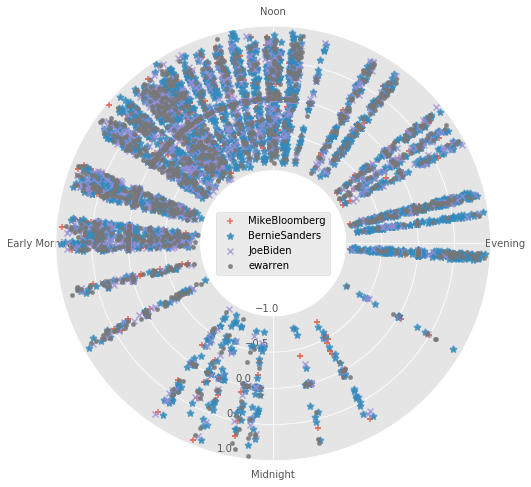

In [144]:
fig, axes = plt.subplots(1,len(real_candidates), figsize=(12,8))
legends = {'ewarren': '.', 'BernieSanders':'*', 'MikeBloomberg':'+', 'JoeBiden':'x'}
for count, candidate in enumerate(real_candidates):
    subset = data['2020-02-25':'2020-03-03'].query(f'name=="{candidate}"')
    subset['theta'] = winter_time(subset.index)
    fig = plt.subplot(polar=True)
    ax = plt.gca()
    ax.set_rorigin(-2)
    ax.set_rlim(-1,1)
    ax.set_theta_zero_location('S', 210)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(225)
    offset = [210,300,30,120]
    ax.set_rticks([-1,-.5,0,.5,1])
    ax.set_thetagrids(angles = offset,
                      labels = ('Midnight', 'Early Morning', 'Noon', 'Evening'))
    c = ax.scatter(subset['theta'], subset['sentiment'], alpha=0.75, marker=legends[candidate], linewidths=2)
    plt.legend(real_candidates)

## Word Frequencies

#### Initial look in: checking stopwords

In [146]:
word_count = Counter(" ".join([re.sub(r'\s',' ',tweet).strip() for tweet in data.clean_text.values]).split())
word_count.most_common(10)

[('the', 3065),
 ('to', 2359),
 ('a', 2099),
 ('you', 1694),
 ('is', 1679),
 ('I', 1538),
 ('and', 1419),
 ('of', 1285),
 ('for', 1199),
 ('in', 1061)]

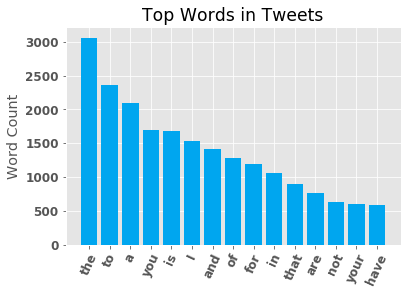

In [349]:
plt.bar([word[0] for word in word_count.most_common(15)], [word[1] for word in word_count.most_common(15)], color='#00A6EF')
plt.xticks(rotation=65)
plt.ylabel('Word Count')
plt.title('Top Words in Tweets')
plt.show();

#### Remove Stop Words

In [352]:
# Set new default plotting parameters
plt.rc('font', weight='bold', size=11)

In [148]:
stopwords_list=stopwords.words('english') +list(string.punctuation)
stopwords_list += ["&amp;","'",'"','...','``','…','’','‘','“',"''",'""','”','”','co',"'s'",'\'s','n\'t','\'m','\'re','amp','https']

#### All Tweets from Public

In [184]:
poli_freq = wordfrequency(raw_data.clean_text.values, 20)

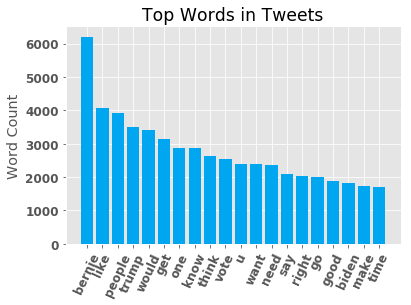

In [353]:
plt.bar([word[0] for word in poli_freq], [word[1] for word in poli_freq], color='#00A6EF')
plt.xticks(rotation=65)
plt.ylabel('Word Count')
plt.title('Top Words in Tweets')
plt.show;

#### Tweets Broken Down by Candidate

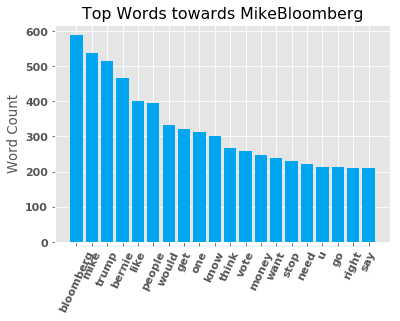

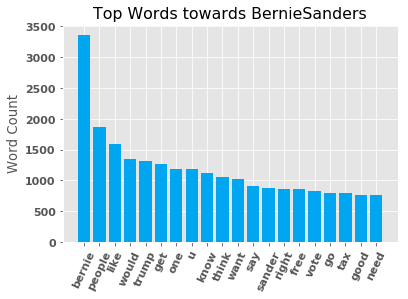

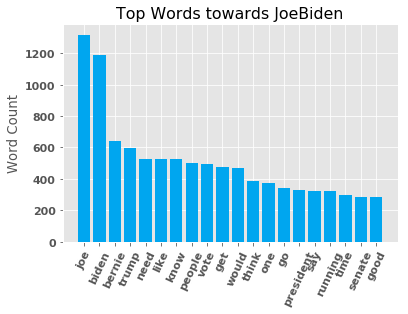

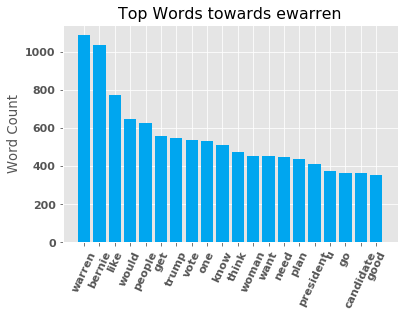

In [356]:
for candidate in real_candidates:
    poli_freq = wordfrequency(raw_data.query(f'name =="{candidate}"').clean_text.values, 20)
    fig = plt.figure()
    plt.bar([word[0] for word in poli_freq], [word[1] for word in poli_freq], color='#00A6EF')
    plt.xticks(rotation=65)
    plt.ylabel('Word Count')
    plt.title(f'Top Words towards {candidate}')
    plt.show;

### WordClouds

#### Candidates

In [181]:
raw_data['clean_text'], raw_data['hashtag'] = zip(*raw_data.text.map(strip_tweets))

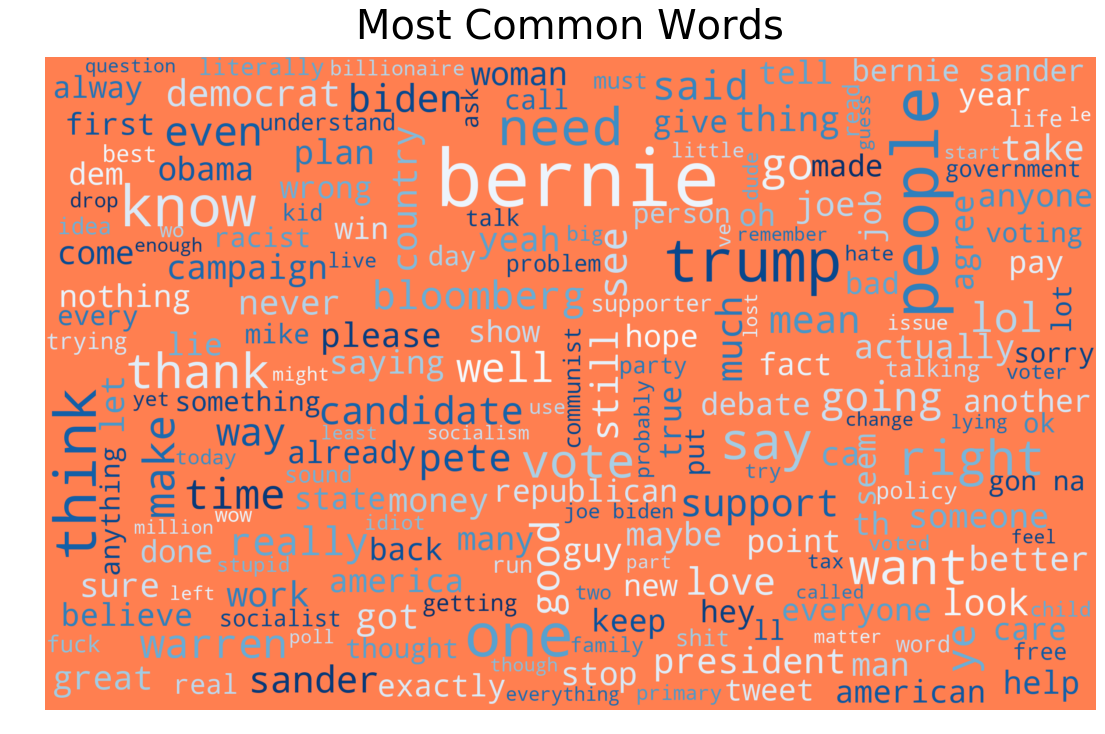

In [388]:
create_wordcloud(raw_data.clean_text.values)

#### General Public

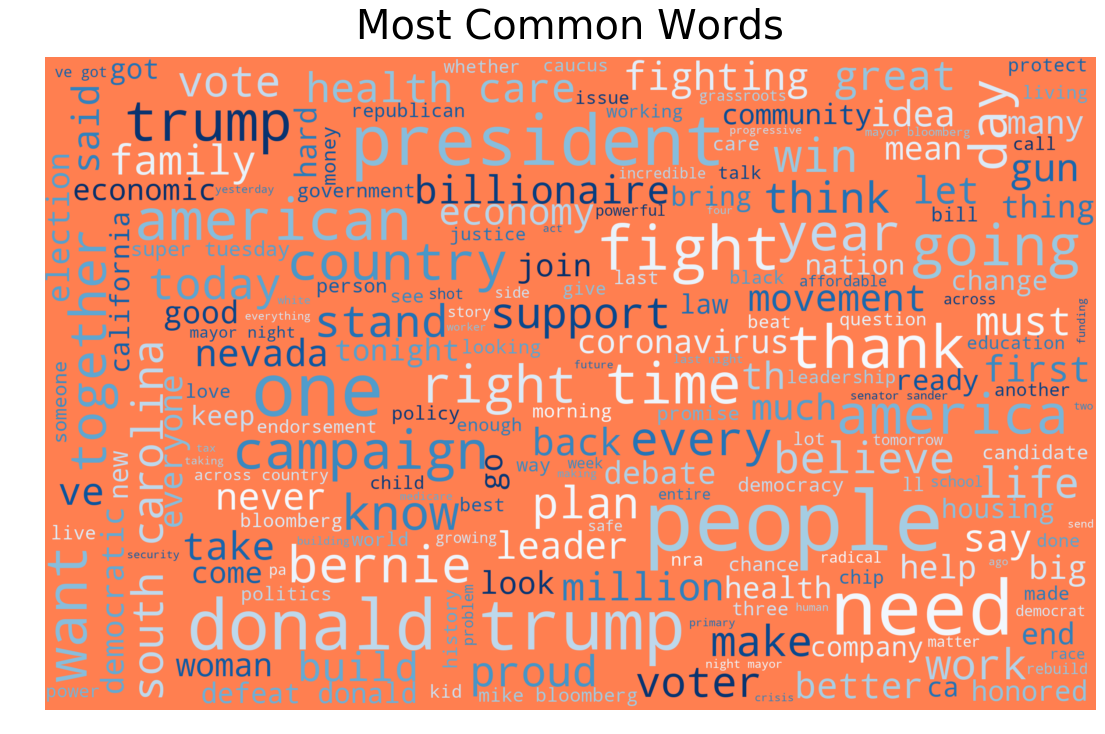

In [387]:
create_wordcloud(cand_data.clean_text.values)